# Gaussian Process 

#### Books / blog posts
Gaussian Process Book http://www.gaussianprocess.org/gpml/ <br />
A Visual Exploration of Gaussian Processes https://distill.pub/2019/visual-exploration-gaussian-processes/  <br />
Geoff Pleiss Ph.D. Thesis on GPyTorch https://geoffpleiss.com/static/media/gpleiss_thesis.d218bc00.pdf

#### Lectures / tutorials
Probebelistic ML https://www.youtube.com/playlist?list=PL05umP7R6ij1tHaOFY96m5uX3J21a6yNd <br />
ML Tutorial: Gaussian Processes (Richard Turner) https://www.youtube.com/watch?v=92-98SYOdlY <br />
Bayesian Deep Learning and Probabilistic Model Construction - ICML 2020 Tutorial https://www.youtube.com/watch?v=E1qhGw8QxqY

#### Beyond basics
Sparse Gaussian Processes (https://proceedings.neurips.cc/paper/2005/file/4491777b1aa8b5b32c2e8666dbe1a495-Paper.pdf) <br />
Gaussian processes for big data (https://arxiv.org/abs/1309.6835) <br />
Scalable Variational Gaussian Process Classification (http://proceedings.mlr.press/v38/hensman15.pdf) <br />
Robust Deep Gaussian Processes (https://arxiv.org/abs/1904.02303) <br />
Parametric Gaussian Process Regressors (https://arxiv.org/pdf/1910.07123.pdf) <br />
Neural Processes (https://arxiv.org/abs/1807.01622) <br />

In [1]:
import itertools
import numpy as np
from numpy.random import multivariate_normal
from scipy.linalg import cho_solve, cho_factor
import scipy
import matplotlib.pyplot as plt

In [2]:
np.random.seed(100)

### Plot Functions

In [3]:
n = 500 # number of grip-points for plotting
plt_y_min, plt_y_max = -1.5, 6.5
plt_x_min, plt_x_max = -8, 8
x_grid = np.linspace(-plt_x_min, plt_x_min, 100)[:, np.newaxis]

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [5]:
def plot_data(X,Y,x_grid,y_true):
    plt.scatter(X, Y, color='b')
    plt.errorbar(X, Y, yerr=noise_scale, fmt='o')
    plt.plot(x_grid[:,0], y_true[:,0], color='lightblue')
    plt.fill_between(x_grid[:,0], y_true[:,0] - noise_scale / 2, y_true[:,0] + noise_scale / 2, alpha=0.1, color='lightblue')
    plt.ylim(-1.5,6.5)

In [6]:
def GaussPDFscaled(y, m, s):
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

In [7]:
def plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    yy = np.linspace(plt_y_min, plt_y_max, mpost.shape[0]).reshape([mpost.shape[0],1])
    Ppost = GaussPDFscaled(yy, mpost[::-1], stdpo)
    ax[0].imshow(Ppost, extent=[plt_x_min, plt_x_max, plt_y_min, plt_y_max], aspect="auto", origin="lower", cmap="Greys", alpha=0.4)
    ax[0].scatter(X, Y, color='b')
    ax[0].errorbar(X, Y, yerr=noise_scale, fmt='o')
    ax[0].plot(x_grid[:,0], y_true[:,0], color='lightblue')
    ax[0].plot(x_grid, mpost + 2 * stdpo, "-", color="lightcoral")
    ax[0].plot(x_grid, mpost - 2 * stdpo, "-", color="lightcoral")
    ax[0].plot(x_grid, mpost + 2 * stdpo + 2 * noise_scale, "-", color="gold")
    ax[0].plot(x_grid, mpost - 2 * stdpo - 2 * noise_scale, "-", color="gold")
    ax[0].fill_between(x_grid[:,0], y_true[:,0] - noise_scale / 2, y_true[:,0] + noise_scale / 2, alpha=0.1, color='lightblue')
    ax[0].set_ylim(plt_y_min, plt_y_max)
    ax[0].plot(x_grid[:,0], mpost[:,0], color="r")
    for i in range(spost.shape[1]):
        ax[0].plot(x_grid[:,0], spost[:,i], "--", color="r", alpha=0.2)
    ax[1].plot(x_grid[:,0], stdpo[:,0], "-", color="k")

# Background

## Gaussian Distributions

Definition: $p(x)=\frac{1}{\sigma \sqrt[]{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} :=  \mathcal{N}(x;\mu,\,\sigma^{2})$


In [8]:
samples = np.random.normal(0,1,10000) # $X \sim \mathcal{N}(\mu,\,\sigma^{2})$
def pdf(x, mean, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(- (x-mean)**2 / (2*sigma**2))
p_x = pdf(x_grid, 0, 1)

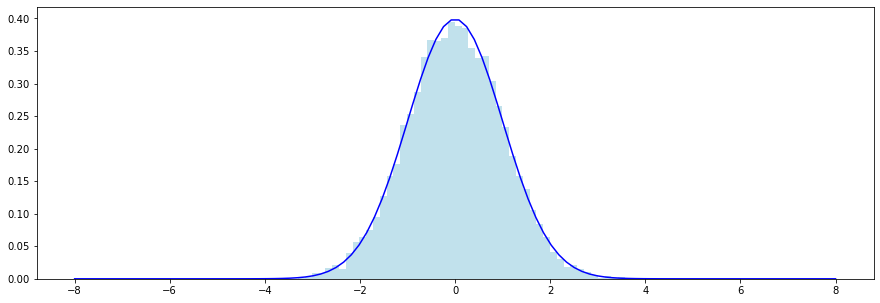

In [9]:
plt.plot(x_grid, p_x[:,0], color='b')
plt.hist(samples, 50, density=True, facecolor='lightblue', alpha=0.75)
plt.show()

products of Gaussian are Gaussians: $\mathcal{N}(x;a,A)\mathcal{N}(x;b,B)=\mathcal{N}(x;c,C)\mathcal{N}(x;a,A) \;\; C:=(A^{-1}+B^{-1})^{-1} \;\;  c:= C(A^{-1}a+B^{-1}b)$

multiply by a constant: $c \mathcal{N}(x;a,A)=\mathcal{N}(x;c a,c A c^T)$

## Bayes' Rule

$p(x|y) = \frac{p(y|x)p(x)}{\int_{}^{} p(x)p(y|x) \,dx}$

Let $p(x)=\mathcal{N}(x; \mu,\,\sigma^{2})$ and $p(y|x)=\mathcal{N}(y; x, \mathcal{v}^2)$

Then $p(x|y)=\mathcal{N}(x; m, s^2)$ with $s^2 := \frac{1}{\sigma^{-2} + \mathcal{v}^{-2}}$ and $m := \frac{\sigma^{-2}\mu + \mathcal{v}^{-2}y}{\sigma^{-2} + \mathcal{v}^{-2}}$

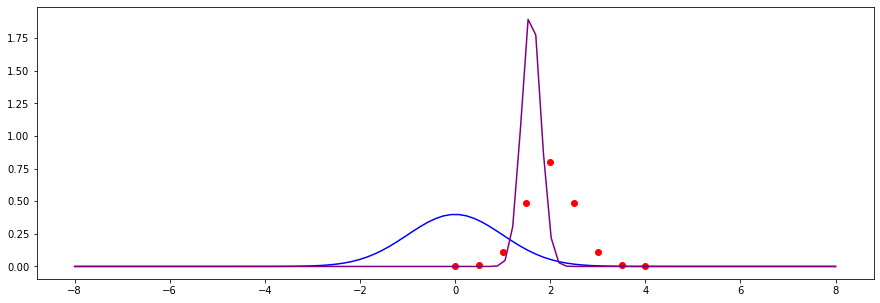

In [10]:
X = np.linspace(0, 4, 9)
Y = pdf(X, 2, 0.5)
p_x = pdf(x_grid, 0, 1)
ss = 1/(1+1/0.5**2)
m =(1/0.5**2 * Y).sum()/ 1/(1+1/0.5**2)
p_xy = pdf(x_grid, m, ss)
plt.scatter(X,Y, color='r')
plt.plot(x_grid, p_x, color='b')
plt.plot(x_grid, p_xy, color='purple')
plt.show()

# Gaussian Process for Regression

Following the "weight-space view" in the Gaussian Process for ML book [1] and the Probabelistic ML Class of Prof. Philipp Hennig [2].

[1] http://www.gaussianprocess.org/gpml/ <br />
[2] https://www.youtube.com/playlist?list=PL05umP7R6ij1tHaOFY96m5uX3J21a6yNd <br />

## Generate Regression Data

We generate 12 data points following a multipolynomial function plus gaussian noise.

In [11]:
def data_function(x, noise_scale=0):
    true_Y = -0.0005*np.power(x, 4) + -0.008*np.power(x, 3) + 0.03*np.power(x, 2) + 0.7 * np.power(x, 1) + 2
    return true_Y + np.random.normal(0, scale=noise_scale, size=true_Y.shape)

In [12]:
data_points = 12
noise_scale = 0.4
data_window = (plt_x_min+1, plt_x_max-1)

In [13]:
X = np.random.uniform(*data_window, size=data_points)[:, np.newaxis]
Y = data_function(X, noise_scale)
y_true = data_function(x_grid)

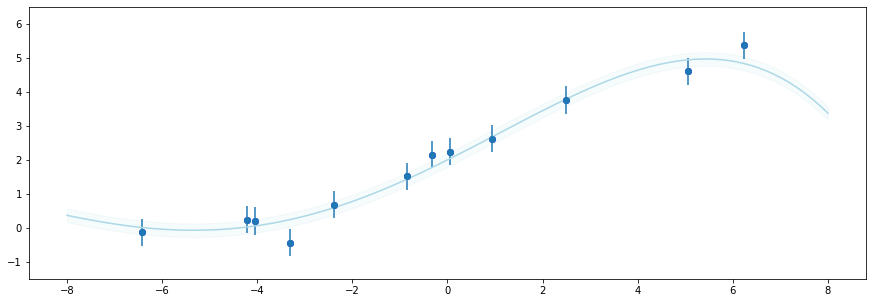

In [14]:
plot_data(X,Y,x_grid,y_true)

## Parametric Regression

Linear regression: $f(x) = w_1 + w_2*x  = \phi(x)^T\textbf{w} $   with feature function   $\phi_x := \phi(x) = [1, x]^T$  
Polynomial regression: $f(x) = w_1 + w_2*x + w_3*x^2 = \phi(x)^T\textbf{w} $   with feature function   $\phi_x := \phi(x) = [1, x, x^2]^T$  

In [15]:
def phi(x): 
    return np.power(x, range(3)) # 1 + x + x^2 + ...

Using OLS to estimate the polynomial regression coefficients:


$S(\textbf{w}) = || y - f(x) ||^2 $  
$S(\textbf{w}) = y^2 - 2y\phi(x)^T\textbf{w} + \phi(x)^T\textbf{w}^T \phi(x) \textbf{w} $  
$\frac{\partial{S(\textbf{w})}}{\partial{\textbf{w}}} = - 2y\phi(x)^T + 2 \phi(x)^T \phi(x) \textbf{w}  $  
$\textbf{w} = [\phi(x)^T \phi(x)]^{-1} \phi(x)^T y$

In [16]:
xx_inv = np.linalg.inv(phi(X).T @ phi(X))
xy = phi(X).T @ Y
weights = xx_inv @ xy

Make predictions:

In [17]:
y_pred = phi(x_grid) @ weights

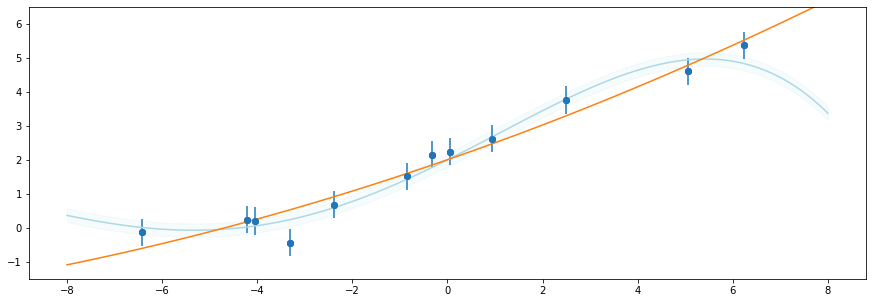

In [18]:
plot_data(X,Y,x_grid,y_true)
p = plt.plot(x_grid[:,0], y_pred[:,0])

## Gaussian Parametric Regression

Drawing weights from a weight distribution $p(w) = \mathcal{N}(w; \mu, \Sigma)$

$f(x)= \phi_x^T\textbf{w} \;\; \forall \;\; \textbf{w} \sim \mathcal{N}(w; \mu, \Sigma)  \;\; \Leftrightarrow \;\;  p(f) = \mathcal{N}(f; \phi_x^T \mu,\, \phi_x^T \Sigma \phi_x)$

BUT, how to get $p(w)$ or $\mu$ and $\Sigma$ ? 

Using Bayes' theorem and gaussian inference:

prior: $p(w) = \mathcal{N}(w; \mu, \Sigma)$

likelihood: $ p(y|\,w,\phi_x) = \mathcal{N}(y; \phi_x^T w, \sigma^2 I) = \mathcal{N}(y; f_x, \sigma^2 I) $

posterior on $\textbf{w}$:  $p(w|\,y,\phi_x) = \frac{p(y|\,w,\phi_x)p(w)}{\int_{}^{} p(y|\,w,\phi_x)p(w) \,dw}$

posterior on $\textbf{w}$: $p(w|\,y,\phi_x) = \mathcal{N}(w; (\Sigma^{-1} + \sigma^{-1} \phi_x^T \phi_x)^{-1} (\Sigma^{-1} \mu + \sigma^{-1} \phi_X \textbf{y})   , (\Sigma^{-1} + \sigma^{-1} \phi_x^T \phi_x)^{-1} ) $

$p(f_{x^*}|\,y,\phi_x) = \mathcal{N}(w; \phi_{x^*}(\Sigma^{-1} + \sigma^{-2} \phi_x^T \phi_x)^{-1} (\Sigma^{-1} \mu + \sigma^{-1} \phi_X \textbf{y})   , \phi_{x^*}(\Sigma^{-1} + \sigma^{-1} \phi_x^T \phi_x)^{-1} )\phi_{x^*}^T $

$p(f_{x^*}|\,y,\phi_x) = \mathcal{N}(w; \phi_{x^*}(A)^{-1} (\Sigma^{-1} \mu + \sigma^{-1} \phi_X \textbf{y})   , \phi_{x^*}(A)^{-1} )\phi_{x^*}^T $ with $A = \Sigma^{-1} + \sigma^{-2} \phi_x^T \phi_x$

In [19]:
F = len(phi(0)) # number of features
sigma_prior = np.eye(F) # prior Sigma

A = sigma_prior + 1/(noise_scale**2) * phi(X).T @ phi(X)
A_inv = np.linalg.inv(A)

mu_weight = 1/(noise_scale**2) * A_inv @ phi(X).T @ Y
sigma_weight = A_inv

mpost = phi(x_grid) @ mu_weight
vpost = phi(x_grid) @ sigma_weight @ phi(x_grid).T

spost = multivariate_normal(mpost.flatten(), vpost, size=10).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

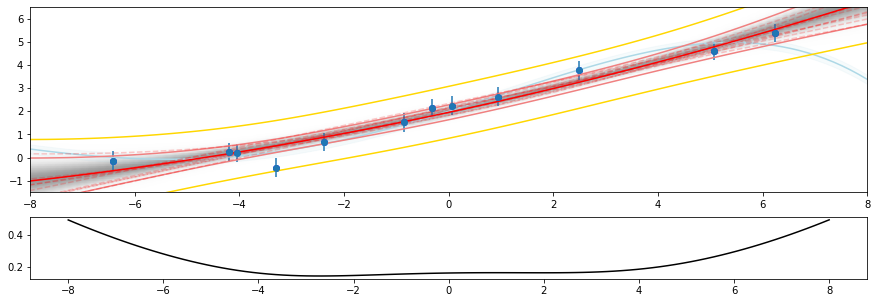

In [20]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

### Replace $\phi(x)$

Feature function may not be the best:

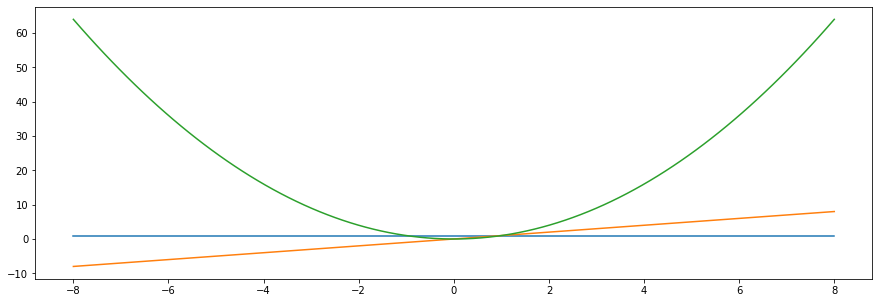

In [21]:
phi_pred = phi(x_grid)
p = plt.plot(x_grid[:,0], phi_pred)

In [22]:
def phi(x, ell=1.0, sigma_f=3.0, features=16): 
    return sigma_f * np.exp(-((x-np.linspace(plt_x_min, plt_x_max,features).T) ** 2) / (ell ** 2) / 2.0)

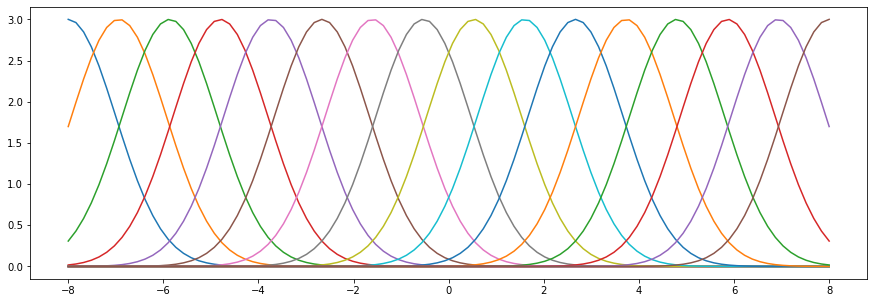

In [23]:
phi_pred = phi(x_grid)
p = plt.plot(x_grid[:,0], phi_pred)

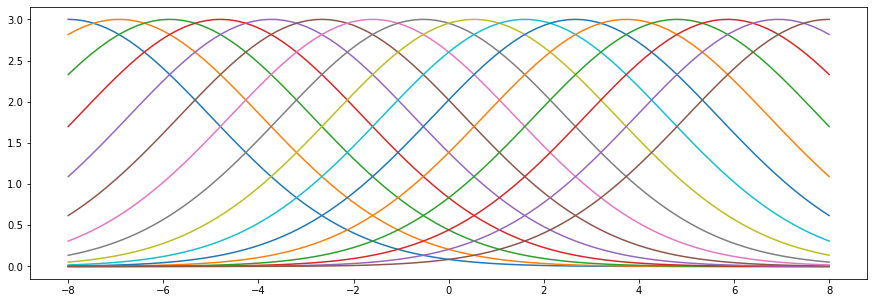

In [24]:
phi_pred = phi(x_grid, ell=3.0)
p = plt.plot(x_grid[:,0], phi_pred)

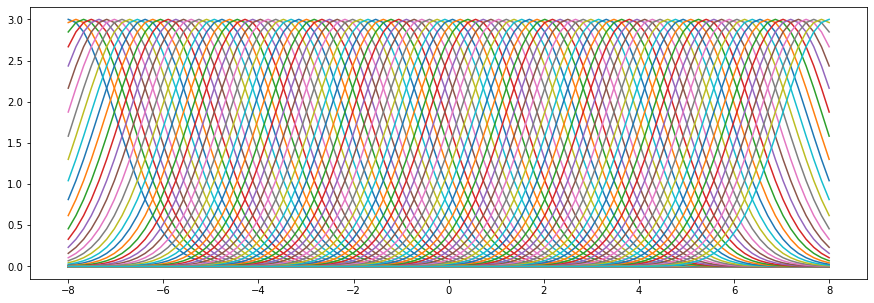

In [25]:
phi_pred = phi(x_grid, features=100)
p = plt.plot(x_grid[:,0], phi_pred)

In [26]:
F = len(phi(0)) # number of features
sigma_prior = np.eye(F) # prior Sigma

A = sigma_prior + 1/(noise_scale**2) * phi(X).T @ phi(X)
A_inv = np.linalg.inv(A)

mu_weight = 1/(noise_scale**2) * A_inv @ phi(X).T @ Y
sigma_weight = A_inv

mpost = phi(x_grid) @ mu_weight
vpost = phi(x_grid) @ sigma_weight @ phi(x_grid).T

spost = multivariate_normal(mpost.flatten(), vpost, size=10).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

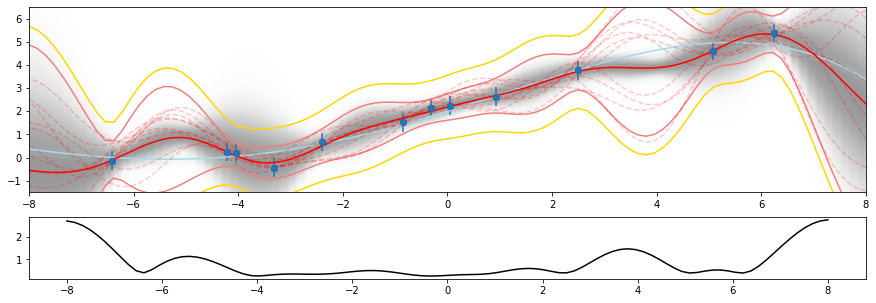

In [27]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

### Kernel trick

$p(f_{x^*}|\,y,\phi_x) = \mathcal{N}(w; \phi_{x^*}(\Sigma^{-1} + \sigma^{-2} \phi_x^T \phi_x)^{-1} (\Sigma^{-1} \mu + \sigma^{-1} \phi_X \textbf{y})   , \phi_{x^*}(\Sigma^{-1} + \sigma^{-1} \phi_x^T \phi_x)^{-1} )\phi_{x^*}^T $

$A = \Sigma^{-1} + \sigma^{-2} \phi_x^T \phi_x$

$p(f_{x^*}|\,y,\phi_x) = \mathcal{N}(w; \phi_{x^*}(A)^{-1} (\Sigma^{-1} \mu + \sigma^{-1} \phi_X \textbf{y})   , \phi_{x^*}(A)^{-1} )\phi_{x^*}^T $

In [28]:
A = sigma_prior + 1/(noise_scale**2) * phi(X).T @ phi(X)
A_inv = np.linalg.inv(A)

mu_weight = 1/(noise_scale**2) * A_inv @ phi(X).T @ Y
sigma_weight = A_inv

mpost = phi(x_grid) @ mu_weight
vpost = phi(x_grid) @ sigma_weight @ phi(x_grid).T

The invertation on A depents on the features size:

In [29]:
print("invert shape:", A.shape)

invert shape: (16, 16)


We apply the kernel trick to change this to the sample size:

$K = \phi_x^T \Sigma \phi_x$

$p(f_{x^*}|\,y,\phi_x) = \mathcal{N}(w; \phi_{x^*}^T \Sigma \phi_{x} (K + \sigma^{-2} I)^{-1} \textbf{y} , \phi_{x^*}^T \Sigma \phi_{x^*} - \phi_{x^*}^T \Sigma (K + \sigma^{-2} I)^{-1} \phi_x^T  \Sigma \phi_{x^*}  $

In [30]:
#mu_weight without @Y 
A = sigma_prior + 1/(noise_scale**2) * phi(X).T @ phi(X)
mu_pre_A = 1/(noise_scale**2) * np.linalg.inv(A)   @ phi(X).T 

K = phi(X) @ sigma_prior @ phi(X).T
mu_pre_K = sigma_prior @ phi(X).T @ np.linalg.inv(K  + noise_scale**2 * np.eye(data_points))

print(np.allclose(mu_pre_A, mu_pre_K))

True


The invertation on A depents on the data points:

In [31]:
print("invert shape:", K.shape)

invert shape: (12, 12)


In [32]:
K = phi(X) @ sigma_prior @ phi(X).T
m_pre = phi(x_grid) @ sigma_prior @ phi(X).T @ np.linalg.inv(K + noise_scale**2 * np.eye(data_points))

mpost = m_pre @ Y
vpost = phi(x_grid) @ sigma_prior @ phi(x_grid).T - m_pre @ (phi(X) @ sigma_prior @ phi(x_grid).T)

In [33]:
spost = multivariate_normal(mpost.flatten(), vpost, size=10).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

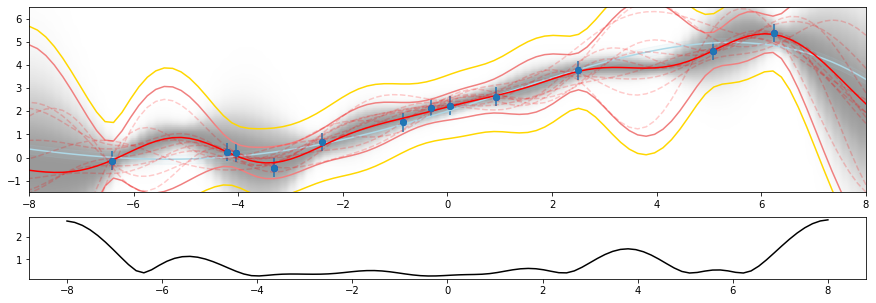

In [34]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

#### Define a kernel

In [35]:
def kernel(a, b):  
    return phi(a) @ sigma_prior @ phi(b).T

a KxL , b KxH -> c LxH

In [36]:
kXX = kernel(X, X) 
kxX = kernel(x_grid, X)
kxx = kernel(x_grid, x_grid)

m_pre = kxX @ np.linalg.inv(kXX + noise_scale**2 * np.eye(data_points))

mpost = m_pre @ Y
vpost = kxx - m_pre @ kxX.T

spost = multivariate_normal(mpost.flatten(), vpost, size=10).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

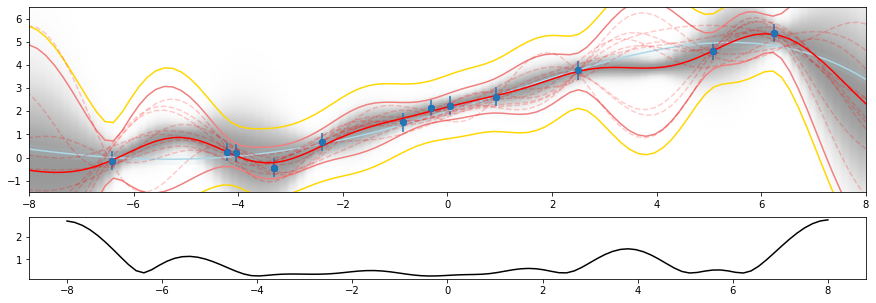

In [37]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

## Gaussian Process for Regression

Use a more fancy kernel

In [38]:
def kernel_builder(f):
    return lambda a, b: np.array(
        [[ np.float(f(a[i], b[j])) for j in range(b.size)] for i in range(a.size)]
    )

In [39]:
def SE(a, b, ell, sigma_f=3): # squared exponential kernel
    return sigma_f ** 2 * np.exp(-((a-b) ** 2) / (2.0 * ell ** 2))

kernel = kernel_builder(lambda a, b: SE( a, b, ell=1.0, sigma_f=3))

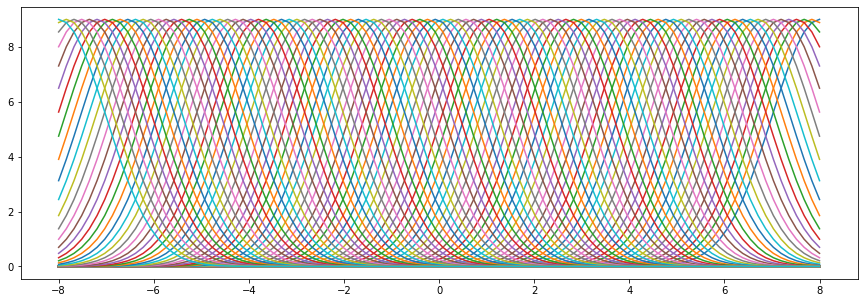

In [40]:
phi_pred = kernel(x_grid, x_grid)
p = plt.plot(x_grid[:,0], phi_pred)

In [41]:
kxx = kernel(x_grid, x_grid) 
kXX = kernel(X, X) 
kxX = kernel(x_grid, X)

m_pre = kxX @ np.linalg.inv(kXX + noise_scale ** 2 * np.eye(data_points))
mpost = m_pre @ Y
vpost = kxx - m_pre @ kxX.T

spost = multivariate_normal(mpost.flatten(), vpost, size=5).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

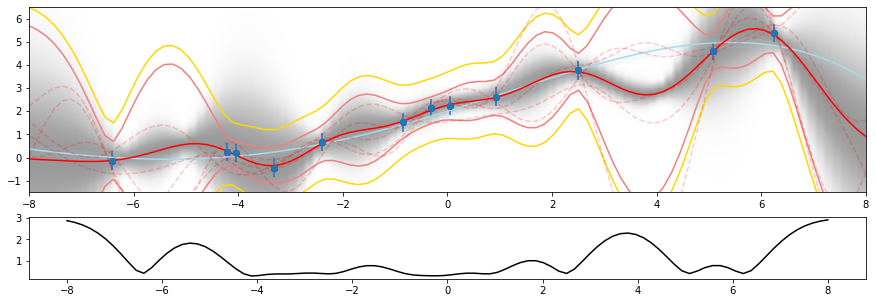

In [42]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

add a mean function for normalizing inputs:

In [43]:
def mean_function(x, const=2):
    return x * 0.0 + const

In [44]:
mx = mean_function(x_grid) 
kxx = kernel(x_grid, x_grid) 

mX = mean_function(X) 
kXX = kernel(X, X) 
kxX = kernel(x_grid, X)

m_pre = kxX @ np.linalg.inv(kXX + noise_scale ** 2 * np.eye(data_points))
mpost = mx + m_pre @ (Y - mX)
vpost = kxx - m_pre @ kxX.T

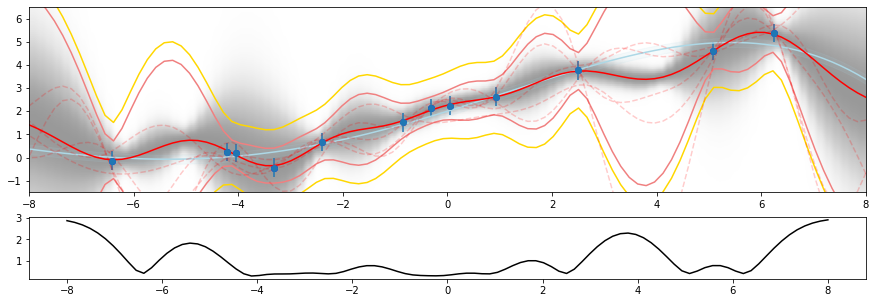

In [45]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

use cholesky decomposition to reduce computation: $O(n^3) \Rightarrow O(n^3 / 3)$

In [46]:
m = mean_function(x_grid) 
kxx = kernel(x_grid, x_grid) 
s = multivariate_normal(m.flatten(), kxx, size=5).T
stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]

G = kXX + noise_scale ** 2 * np.eye(data_points)
G = cho_factor(G)
kxX = kernel(x_grid, X) 
A = cho_solve(G, kxX.T).T 

# posterior P(f_x|Y) = N(f_x, mpost, vpost)
mpost = mean_function(x_grid ) + A @ (Y - mean_function(X))
vpost = kernel(x_grid, x_grid) - A @ kxX.T
spost = multivariate_normal(mpost.flatten(), vpost, size=5).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

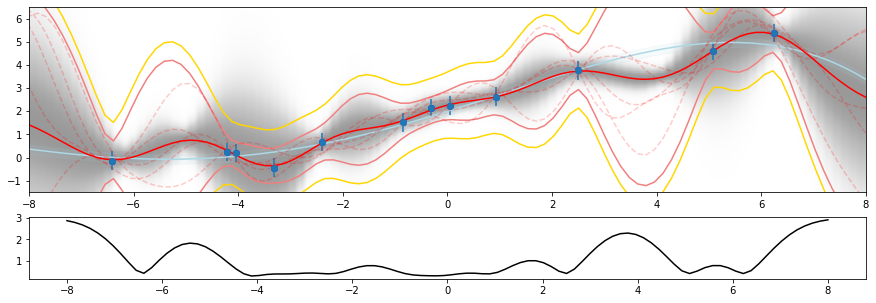

In [47]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

## Model Selection (aka hyperparameter optimization)

### Optimization Objetice

We follow *Chapter 5* in the Gaussian Processes Book.
First we recap our hyperparameter:

In [48]:
sigma_f = 1.0
l = 1.0
noise_scale = 1.0

and the likelihood: $ p(y|X,\textbf{f})$ with $ \textbf{f} = K_{xx}^\top (K_{XX} + \sigma^2_n I)^{-1} \textbf{y} $ (2.25)

Given a prior $p(\textbf{f} \mid \Theta)$ we can create the log marginal likelihood

$log p(\textbf{y}\mid X, \Theta) = \int p(y|X,\textbf{f})  p(\textbf{f} \mid \Theta) d\textbf{f}$ (5.4)

$log p(\textbf{y}\mid X, \Theta) = - \frac{1}{2} \textbf{y}^\top K_y^{-1} \textbf{y} - \frac{1}{2} log \mid K_y \mid -  \frac{n}{2} log 2 \pi$ with $K_y = K_f + \sigma^2_n I$   (5.8)

In [49]:
def log_p_y_X_theta(Y, X, sigma_f, l, noise_scale):

    kernel = kernel_builder(lambda a, b: SE( a, b, l, sigma_f))
    
    K_f = kernel(X, X) 
    K_y = K_f + noise_scale ** 2 * np.eye(data_points)
    log_p_y_X_theta = -0.5 * Y.T @ np.linalg.inv(K_y) @ Y - .5 * np.log(np.linalg.det(K_y)) - data_points / 2 * np.log(2 * np.pi) 
    return log_p_y_X_theta[0,0]

Probability of **y** given our hyparparameters 

In [50]:
p_y_X_theta = np.exp(log_p_y_X_theta(Y, X, sigma_f, l, noise_scale))
p_y_X_theta

6.897594070566864e-14

In [51]:
kernel = kernel_builder(lambda a, b: SE( a, b, ell=l, sigma_f=sigma_f))

kxx = kernel(x_grid, x_grid) 
kXX = kernel(X, X) 
kxX = kernel(x_grid, X)

m_pre = kxX @ np.linalg.inv(kXX + noise_scale ** 2 * np.eye(data_points))
mpost = m_pre @ (Y)
vpost = kxx - m_pre @ kxX.T

spost = multivariate_normal(mpost.flatten(), vpost, size=5).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

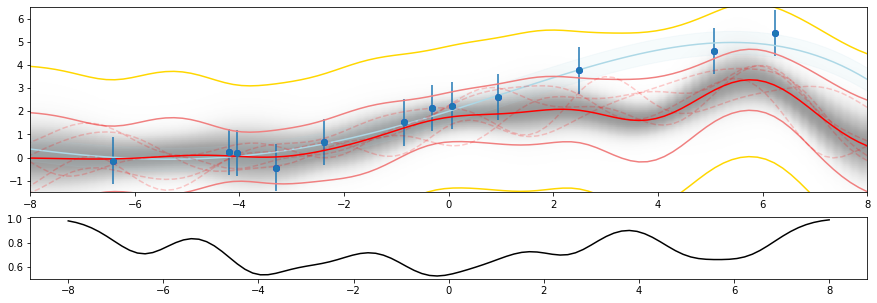

In [52]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

### Optimization

Plot the hyperparameter landscape

In [53]:
l_range = np.linspace(0.01,10, 10)
noise_scale_range = np.linspace(0.001,2, 2)

theta = list(itertools.product(*(l_range, noise_scale_range)))
theta = np.asarray(theta)

In [54]:
marginal_objective = lambda l_, sigma_f_: log_p_y_X_theta(Y, X, sigma_f, l_, sigma_f_)

log_p_y_X_theta_matrix = list(map(marginal_objective, *theta.T))

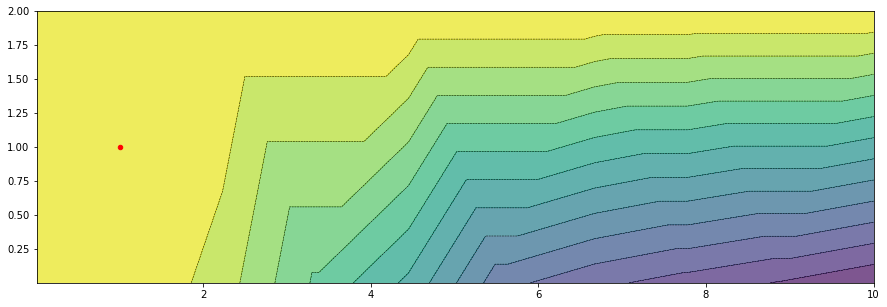

In [55]:
plt.tricontour(*theta.T, log_p_y_X_theta_matrix, 15, linewidths=0.5, colors='k')
plt.tricontourf(*theta.T, log_p_y_X_theta_matrix, 15, alpha=.7)
plt.scatter(l, noise_scale, s=20, c='red');

Optimize the hyperparameters (easy since the marginal likelihood is fully differentiable )

In [56]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

def GP_opjective(z):
    return -1*log_p_y_X_theta(Y, X, sigma_f=z[2], l=z[0], noise_scale=z[1])

start_value = np.array([l, noise_scale, sigma_f])
result = differential_evolution(func=GP_opjective, bounds=[(0,10), (0,10), (0,10)],polish=False)
l_star, noise_scale_star, sigma_f_star = result.x

In [57]:
for param, value in zip(["l_star", "noise_scale_star", "sigma_f_star" ], [l_star, noise_scale_star, sigma_f_star]):
    print(f"{param:16}: {value}")

l_star          : 7.694253237162263
noise_scale_star: 0.31483358554511565
sigma_f_star    : 3.227504113669193


Probability of **y** given the optimized hyparparameters 

In [58]:
p_y_X_theta = np.exp(log_p_y_X_theta(Y, X, sigma_f_star, l_star, noise_scale_star))
p_y_X_theta

1.029225706289392e-05

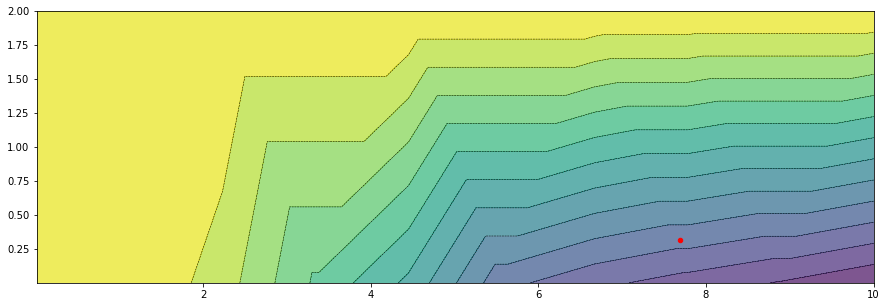

In [59]:
plt.tricontour(*theta.T, log_p_y_X_theta_matrix, 15, linewidths=0.5, colors='k')
plt.tricontourf(*theta.T, log_p_y_X_theta_matrix, 15, alpha=.7)
plt.scatter(l_star, noise_scale_star, s=20, c='red');

Insert our found hyperparameters $l^\star, noisescale^\star, sigma_f^\star$

### Final Inference

In [60]:
kernel = kernel_builder(lambda a, b: SE( a, b, ell=l_star, sigma_f=sigma_f_star))

kxx = kernel(x_grid, x_grid) 
kXX = kernel(X, X) 
kxX = kernel(x_grid, X)

m_pre = kxX @ np.linalg.inv(kXX + noise_scale_star ** 2 * np.eye(data_points))
mpost = m_pre @ Y
vpost = kxx - m_pre @ kxX.T

spost = multivariate_normal(mpost.flatten(), vpost, size=5).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

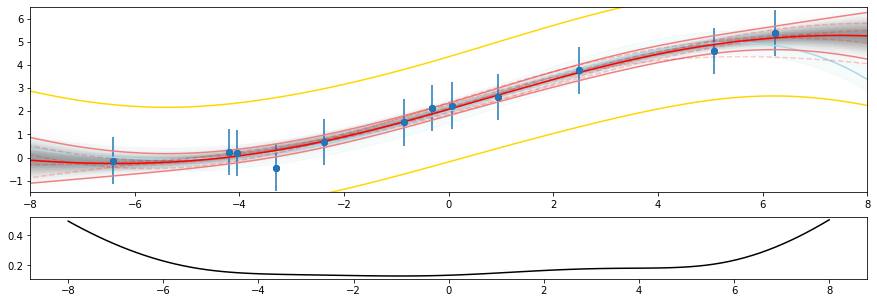

In [61]:
plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)

Plugging the noise-free latent **f** in the Likielihood $P(y \mid \textbf{f})$ 

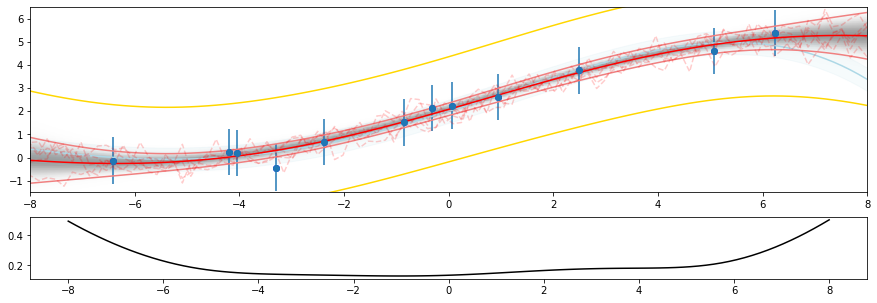

In [62]:
spost = multivariate_normal(mpost.flatten(), vpost + noise_scale_star ** 2 * np.eye(vpost.shape[0]), size=5).T
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]

plot_prediction(X,Y, y_true, x_grid, mpost, spost, stdpo)